# Forecasting BART hourly ridership (univariate)

In [27]:
import logging
import os
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import Forecaster, ForecastingModel, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.tensor_utils import periodic_cumsum, periodic_features, periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

from bart_uni2 import Model

%matplotlib inline
pyro.enable_validation(True)
logging.getLogger("pyro").setLevel(logging.DEBUG)
logging.getLogger("pyro").handlers[0].setLevel(logging.DEBUG)

In [24]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

T, O, D = dataset["counts"].shape
data = dataset["counts"].reshape(T, -1).sum(-1, keepdim=True).log1p()
print(dataset["counts"].shape, data.shape)
covariates = periodic_features(len(data), 365.25 * 24, 7 * 24)

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK
torch.Size([78888, 50, 50]) torch.Size([78888, 1])


In [ ]:
T0 = 0
T1 = 3 * 365 * 24
T2 = T1 + 4 * 7 * 24

pyro.clear_param_store()
pyro.set_rng_seed(20200313)
forecaster = Forecaster(Model("normal"), data[:T1], covariates[:T1],
                        learning_rate=0.1, num_steps=1001, log_every=100)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 8.5394e+08
INFO 	 step  100 loss = 3.66492


torch.Size([100, 672, 1]) torch.Size([672])


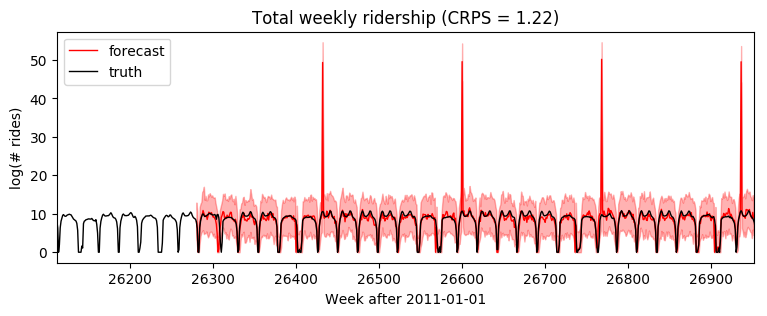

In [26]:
samples = forecaster(data[:T1], covariates[:T2], num_samples=100)
samples = samples.clamp(min=0)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:T2])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', lw=1, label='forecast')
plt.plot(data, 'k-', label='truth', lw=1)
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.legend(loc="best");